In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
import torchvision
import tqdm

import matplotlib.pyplot as plt

from loss import Binary_Cross_Entropy_Loss
from model import Residual_CNN

# 데이터셋 구축

In [2]:
trans=torchvision.transforms.Compose([
            torchvision.transforms.Resize((224,224)),
            torchvision.transforms.ToTensor(),])
train_dataset = torchvision.datasets.ImageFolder("dataset/train_set",transform=trans)
valid_dataset = torchvision.datasets.ImageFolder("dataset/valid_set",transform=trans)
test_dataset = torchvision.datasets.ImageFolder("dataset/test_set",transform=trans)

In [3]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
valid_loader=DataLoader(valid_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=True)

tensor([0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 1, 1, 0])
tensor(0)


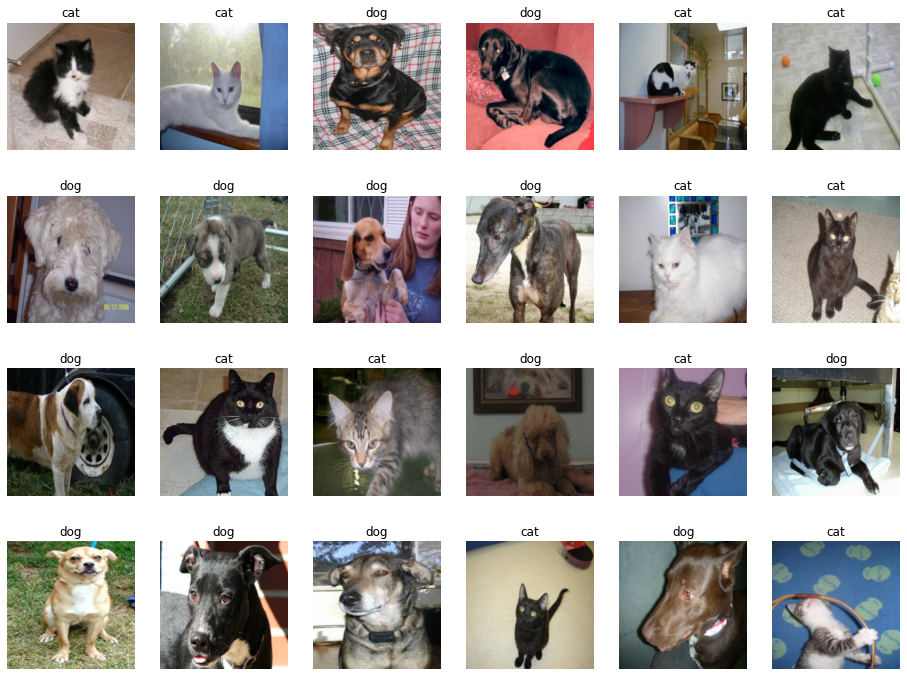

In [4]:
samples, labels = iter(train_loader).next()
print(labels)
print(labels[1])
classes = ["cat","dog"]
fig = plt.figure(figsize=(16,24))
for i in range(24):    
    a = fig.add_subplot(4,6,i+1)    
    a.set_title(classes[labels[i]])    
    a.axis('off')   
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)


# model 선언 및 학습

In [5]:
device=torch.device("cuda:0"if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device)+"\n",
device)

NVIDIA GeForce GTX 1050 Ti
 cuda:0


In [6]:
model=Residual_CNN().to(device)

In [7]:
cost = Binary_Cross_Entropy_Loss
# cost =nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
Epochs=5
train_losses=[]
valid_losses=[]

In [8]:
for epoch in range(Epochs):
    train_loss=0
    valid_loss=0
    model.train()
    for batch,train_set in enumerate(tqdm.tqdm(train_loader)):
        
        train_x,train_y=train_set
        train_x.requires_grad_(requires_grad=True)
        
        train_y=F.one_hot(train_y,2)                           

        train_x=train_x.to(device)
        train_y=train_y.to(device)
        optimizer.zero_grad()

        pred = model(train_x)
        loss = cost(pred, train_y)
        
        loss.backward()
        optimizer.step()

        train_loss +=loss.item()
    
    
    for batch,valid_set in  enumerate(tqdm.tqdm(valid_loader)):
        with torch.no_grad():
            model.eval()
            valid_x,valid_y=valid_set
            valid_y=F.one_hot(valid_y,2)   

            valid_x=valid_x.to(device)
            valid_y=valid_y.to(device)

            pred=model(valid_x)
            loss = cost(pred,valid_y)
        valid_loss+=loss.item()
    
    train_losses.append(train_loss/len(train_dataset))
    valid_losses.append(valid_loss/len(valid_dataset))
    print(f'epoch : {epoch+1} training Loss: {train_loss/len(train_dataset)}')
    print(f'epoch : {epoch+1} valid Loss: {valid_loss/len(valid_dataset)}')

100%|██████████| 63/63 [01:11<00:00,  1.13s/it]


epoch : 1 training Loss: 0.02169214711942798
epoch : 1 valid Loss: 0.021716373175382615


100%|██████████| 63/63 [01:09<00:00,  1.10s/it]


epoch : 2 training Loss: 0.021562561416983383
epoch : 2 valid Loss: 0.02161251562833786


100%|██████████| 63/63 [01:08<00:00,  1.09s/it]


epoch : 3 training Loss: 0.021469452320077433
epoch : 3 valid Loss: 0.02151949542760849


100%|██████████| 63/63 [01:09<00:00,  1.10s/it]


epoch : 4 training Loss: 0.02137643412304699
epoch : 4 valid Loss: 0.021423439413309098


100%|██████████| 63/63 [01:07<00:00,  1.07s/it]

epoch : 5 training Loss: 0.02128914279687561
epoch : 5 valid Loss: 0.021325861543416976


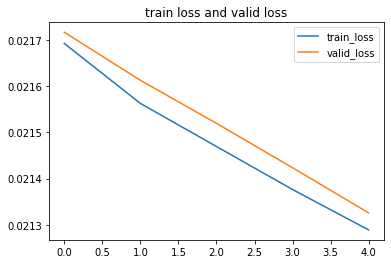

In [9]:
plt.plot(train_losses,label='train_loss')
plt.plot(valid_losses,label='valid_loss')
plt.legend()
plt.title("train loss and valid loss")
plt.show()

# 모델 평가

In [10]:
# test_loss=0
# for batch, testset in  (enumerate(test_loader)):
#     with torch.no_grad():
#         model.eval()
#         test_x,test_y=testset
#         print(test_x.shape, test_y.shape)
#         test_x=test_x.to(device)
#         test_y=test_y.to(device)
#         pred=model(test_x)
        
#         print(pred)    

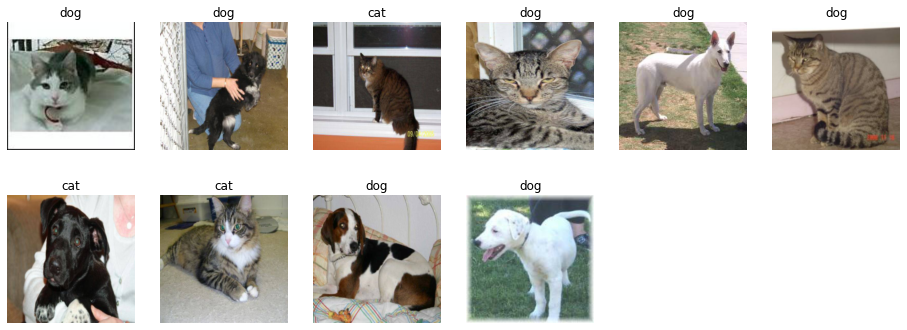

In [17]:
samples, labels = iter(test_loader).next()
samples=samples

model.cpu()
model.eval()
pred=model(samples)
classes = ["cat","dog"]
acc=0
fig = plt.figure(figsize=(16,24))
for i in range(10):    
    if np.argmax(model(samples)[i].detach().numpy()) == labels[i]:
        acc+=1
    a = fig.add_subplot(4,6,i+1)    
    a.set_title(classes[np.argmax(model(samples)[i].detach().numpy())])    
    a.axis('off')   
    a.imshow(np.transpose(samples[i].detach().numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)
print(acc)

6


In [12]:
# for test_x,test_y in  tqdm.tqdm(test_loader):
#     with torch.no_grad():
#         for i in range(test_x.shape[0]):
#             model.eval()
#             test_x=test_x.to(device)[i]
#             test_y=test_y.to(device)[i]
#             pred=model(test_x)
#             print(pred.shape)
#             loss = cost(pred,test_y)
#             break
#     test_loss+=loss.item()    
# print(f'test Loss: {train_loss/len(train_dataset)}')

# CREloss function 

In [13]:
import torch
import torch.nn as nn
import numpy as np
output = [0.8982, 0.805, 0.6393, 0.9983, 0.5731, 0.0469, 0.556, 0.1476, 0.8404, 0.5544]
target = [1]
loss = np.log(sum(np.exp(output))) - output[target[0]]
print(loss) # 2.143818427948945

2.143818427948945


In [14]:
valid_loader=DataLoader(valid_dataset,batch_size=1,shuffle=True)
for bq,data_set in enumerate(valid_loader):
    a,b=data_set
    a=a.to(device)
    b=b.to(device)
    break

In [15]:
output = model(a.float().cuda())
target = F.one_hot(b,2).float().cuda()
print(output,target)
criterion = nn.BCELoss()
loss = criterion(output, target)
print(loss) # tensor(0.6878)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
output = model(a.cuda())
target = F.one_hot(b,2).float().cuda()
print(output,target)
loss=0
loss=torch.mean(-1* (target*torch.log(output)+(1-target)*torch.log(1-output)))
print(loss) # tensor(0.6878)

tensor([[0.4705, 0.4629]], device='cuda:0', grad_fn=<SigmoidBackward0>) tensor([[1., 0.]], device='cuda:0')
tensor(0.6878, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:

loss=(-1)*torch.sum(torch.log(torch.exp(output) / torch.sum(torch.exp(output)))*target)

In [ ]:
output = [0.8982, 0.805, 0.6393, 0.9983, 0.5731, 0.0469, 0.556, 0.1476, 0.8404, 0.5544]
target = [0,1,0,0,0,0,0,0,0,0]
print(len(target))
loss=0
loss=(-1)*np.sum(np.log(np.exp(output) / np.sum(np.exp(output)))*target)
print(loss) # 2.143818427948945

10
2.143818427948945


In [ ]:
import torch
import torch.nn as nn
import numpy as np
output = torch.Tensor([[0.8982, 0.805, 0.6393, 0.9983, 0.5731, 0.0469, 0.556, 0.1476, 0.8404, 0.5544]])
target = torch.LongTensor([1])
criterion = nn.CrossEntropyLoss()
loss = criterion(output, target)
print(loss) # tensor(2.1438)

tensor(2.1438)


In [ ]:
output = torch.Tensor([[0.8982, 0.805, 0.6393, 0.9983, 0.5731, 0.0469, 0.556, 0.1476, 0.8404, 0.5544]])
target = torch.LongTensor([0,1,0,0,0,0,0,0,0,0])
loss=0
loss=(-1)*torch.sum(torch.log(torch.exp(output) / torch.sum(torch.exp(output)))*target)
print(loss) # 2.143818427948945

tensor(2.1438)


In [ ]:
target=torch.Tensor(target)


In [ ]:
target.requires_grad_(requires_grad=True)
print(target.requires_grad)


True
